# Analysis

This notebook creates features from raw tables, runs multiple regressions and visualizes the results.

## 1. Set environment

Import libraries

In [1]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer

# Constantly changing
from disco import cv_bandwidth

The following cell parses json files. Avoid running it again.

Counts:
- All videos
    - 1,928
- All videos with at least one comment in first 12 hours
    - 1,846
- All videos with at least one comment in English in first 12 hours
    - 1,814
- All videos with at least one comment in first 12 hours and excluding fuzzy window
    - 1516
- All videos with at least one comment in English in first 12 hours excluding fuzzy window
    - 1504
- All comments
    - 1,197,454

Read datasets

In [2]:
# Video details table
d1 = pd.read_csv('../../dat/videoDetails.csv')

# Classified comments
# d2 = pd.read_csv('../../dat/videoFlags.csv') # Deprecated (no langid filter & no Nov-10 data)
# d2 = pd.read_csv('../../dat/videoFlagsFuzzy.csv') # Deprecated (no langid filter)
d2 = pd.read_csv('../../dat/videoFlagsFuzzyLangid.csv') # Current (has langid filter and Nov-10 data)

# Create dataframe for analysis
df = pd.merge(d1, d2, on='videoId', how='right')

Create masks for each time window

In [3]:
# Convert publishedAt to timestamp
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

# Sort data by upload date
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

# Start of policy rollout (2021-11-00)
start = pd.Timestamp('2021-11-10 00:00:00')

# Start of post period (24 hours after start)
postStart = start + pd.Timedelta(hours=24)

# Time windows
hours = np.arange(12, 72+1, 12)         # [12, 24, ..., 72]
windows = [f'Post{h}' for h in hours]   # [Post12, Post24, ..., Post72]

# Init dict in which to store masks
donuts = {}


# Create masks for each time window
for h in hours:

    # Set max time of upload before treatment
    lim = start - pd.Timedelta(hours=h)

    # Pre-treatment or post-treatment mask (h: mask)
    donuts[h] = df['publishedAt'].le(lim) | df['publishedAt'].ge(postStart)

## 2. Feature engineering
Turn `definition` to dummy

In [4]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create means from counters

In [5]:
# Create per-video means
for h in hours:

    # NCRs
    df[f'ncr1Post{h}'] = df[f'post{h}CommentsNeg1'] / df[f'post{h}CommentsNum'].replace(0, 1)
    df[f'ncr2Post{h}'] = df[f'post{h}CommentsNeg2'] / df[f'post{h}CommentsNum'].replace(0, 1)
    
    # PCRs
    df[f'pcr1Post{h}'] = df[f'post{h}CommentsPos1'] / df[f'post{h}CommentsNum'].replace(0, 1)
    df[f'pcr2Post{h}'] = df[f'post{h}CommentsPos2'] / df[f'post{h}CommentsNum'].replace(0, 1)
    
    # Relative ratios (constraint: at least one of each)
    df[f'rel1Post{h}'] = np.where(
        df[f'post{h}CommentsNeg1'].gt(0) & df[f'post{h}CommentsPos1'].gt(0),
        df[f'post{h}CommentsNeg1'] / df[f'post{h}CommentsPos1'],
        np.nan
    )
    df[f'rel2Post{h}'] = np.where(
        df[f'post{h}CommentsNeg2'].gt(0) & df[f'post{h}CommentsPos2'].gt(0),
        df[f'post{h}CommentsNeg2'] / df[f'post{h}CommentsPos2'],
        np.nan
    )

Analyze most important words in video titles to create dummy variables

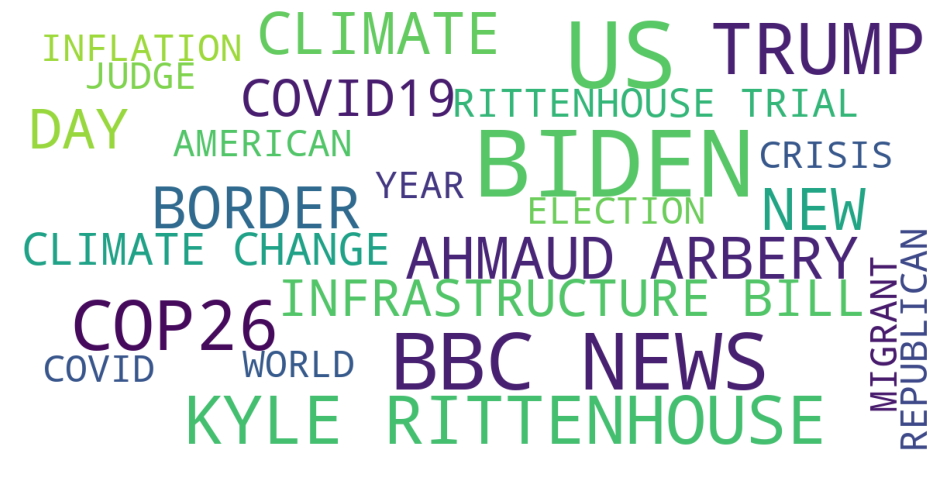

In [6]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()

# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS','S'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

# Show wordcloud
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Create dummy variables by topic

In [7]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
topics = {
    'biden':'biden',
    'trump':'trump',
    'president':'biden|trump',
    'climate':'cop26|cop 26|climate',
    'economy':'inflation|infrastructure|econom',
    'covid':'covid|covid19|covid-19|virus',
    'violence':'kill|murder|assassin| die| dead| shoot| shot'
}

# Create Indicator variables
for topic in topics.keys():
    df[topic] = np.where(df['title'].str.contains(topics[topic]), 1, 0)

Video title sentiment

In [8]:
clf = SentimentIntensityAnalyzer()
df['toneCom'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])
df['tonePos'] = df['title'].apply(lambda x: clf.polarity_scores(x)['pos'])
df['toneNeg'] = df['title'].apply(lambda x: clf.polarity_scores(x)['neg'])

Translate `duration` to seconds.

In [9]:
# YT-duration format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Treatment indicator

In [10]:
df['treat'] = df['publishedAt'].ge(start).astype(int)

Declare running variable $R_i$ and interaction term $R_i \times T_i$

In [11]:
# Running variable
df['r'] = (df['publishedAt'] - start).dt.total_seconds()

# Interaction
df['rTreat'] = df['r'].multiply(df['treat'])

## 3. Descriptive Statistics

### Counts

Number of available videos as a function of $h$

In [12]:
# Init list
d = []

# Iterate over time windows
for h in hours:

    # Append case, before, after and total
    d.append(
        [
            h,
            f'{h+24} hours',
            (df['publishedAt'].le(start - pd.Timedelta(hours=h)) & df[f'post{h}CommentsNum'].gt(0)).sum(),
            (df['publishedAt'].ge(postStart) & df[f'post{h}CommentsNum'].gt(0)).sum(),
            (donuts[h] & df[f'post{h}CommentsNum'].gt(0)).sum()
        ]
    )

# To dataframe
d = pd.DataFrame(data=d, columns=['h','Donut Hole', 'Before', 'After', 'Total'])

# View
d
# print(
#     d.to_latex(
#         caption='Number of available videos',
#         label='tab_dat_nObs',
#         index=False
#     )
# )

,h,Donut Hole,Before,After,Total
0,12,36 hours,666,838,1504
1,24,48 hours,574,841,1415
2,36,60 hours,456,842,1298
3,48,72 hours,423,842,1265
4,60,84 hours,342,842,1184
5,72,96 hours,318,842,1160


### Balance tests

Balance table using a linear stepwise design and excluding the donut hole for $h = 12$.

$$X_i = \gamma_0 + \gamma_1 r_i + \gamma_2 T_i + \gamma_3 (r_i \times T_i) + V_i$$

In [33]:
# Copy data
d = df.copy()

# Create video length (minutes)
d['durationMins'] = d['seconds'].div(60)

# Order frequent-word variables by frequency
X = list(topics.keys()) + ['definition','durationMins','tonePos','toneNeg','toneCom']

# Regress each variable on r and treat
data = []
for x in X:
    m = sm.OLS.from_formula(
        formula=f'{x} ~ r + treat + I(r*treat)',
        data=d,
    ).fit(cov_type='HC0')
    data.append((m.params['treat'], m.pvalues['treat']))

# Summary table
t = pd.DataFrame(data=data, index=X, columns=['Estimated Value','p-value'])
t.index.rename('Covariate', inplace=True)
t.reset_index(inplace=True)

# Print exog that did not pass balance test
print(
    'Variables that did not pass: \n',
    t.loc[t['p-value'].lt(0.1),
    'Covariate'], sep=''
)

# View
t.round(3)

# To latex
# print(
#     t.to_latex(
#         caption='Regression discontinuities on observable characteristics',
#         label='tab_dat_balance',
#         float_format='%.3f',
#         index=False
#     )
# )

Variables that did not pass: 
5         covid
7    definition
Name: Covariate, dtype: object


,Covariate,Estimated Value,p-value
0,biden,-0.022,0.292
1,trump,0.022,0.251
2,president,0.003,0.905
3,climate,0.022,0.253
4,economy,-0.004,0.826
5,covid,0.039,0.012
6,violence,-0.003,0.893
7,definition,0.054,0.048
8,durationMins,2.953,0.254
9,tonePos,0.001,0.923


## 4. Regression Analysis

Convenience functions

In [14]:
# Stars function
def stars(pval):
    if pval <= 0.01:
        return '***'
    elif pval <= 0.05:
        return '**'
    elif pval <= 0.1:
        return '*'
    else:
        return ''

# Function to extract most relevant info from RDD
def get_info(models, dep_vars, hours):

    # Form dataframe
    t =  pd.DataFrame(
        {
            # Targets
            'y':np.repeat(dep_vars, len(hours)),
            # Time windows
            'h':list(hours)*len(dep_vars),
            # Betas
            'T':[models[i].params['treat'] for i in range(len(models))],
            # Standard errors
            'se':[models[i].bse['treat'] for i in range(len(models))],
            # p-values
            'pval':[models[i].pvalues['treat'] for i in range(len(models))],
            # Significance
            'signif':[stars(models[i].pvalues['treat']) for i in range(len(models))],
            # Mean at r=0
            'mean':[models[i].predict({'r':0, 'treat':0}).item() for i in range(len(models))],
            # R2
            'R2':[models[i].rsquared for i in range(len(models))],
            # Number of observations
            'nobs':[int(models[i].nobs) for i in range(len(models))]
        }
    )

    # Reindex table
    return t.set_index(['y', 'h'])

### 4.1. Fit models
The following models consider a donut hole as a funtion of $h$.

`d1:` $Y_i = \beta_0 + \beta_1 r_i + \beta_2 T_i + \beta_3 (T_i \times r_i) + U_i$

`d2:` $Y_i = \beta_0 + \beta_1 r_i + \beta_2 r_i^2 + \beta_3 T_i + \beta_4 (T_i \times r_i) + \beta_5 (T_i \times r_i)^2 + V_i$

In [15]:
# Rename post{H}CommentsNum to make it compatible
for col in df.columns:
    if 'CommentsNum' in col:
        df.rename(
            columns={col:f'commentsNum{col[:6].title()}'},
            inplace=True
        )

# Minimum number of comments in each video
min_comments = 0

# Empty lists to store results in
d1, d2 = [], []

# Iterate over targets
for target in ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2', 'commentsNum']:

    # Iterate over Post%H windows
    for h, post in zip(hours, windows):

        # Masks for `rel1` & `rel2`
        if 'rel' in target:
            mask = donuts[h] & df[f'{target}{post}'].notna()
        
        # Masks for `ncr`, `pcr` and `commentsNum`
        else:
            mask = donuts[h] & df[f'commentsNum{post}'].gt(min_comments)

        # Linear and quad formulas for post{h}CommentsNum
        p1 = f'{target}{post} ~ treat + r + I(r*treat)'
        p2 = f'{target}{post} ~ treat + r + I(r**2) + I(r*treat) + I((r*treat)**2)'

        # Fit models
        m1 = sm.OLS.from_formula(formula=p1, data=df[mask]).fit(cov_type='HC0')
        m2 = sm.OLS.from_formula(formula=p2, data=df[mask]).fit(cov_type='HC0')

        # Append to list
        d1.append(m1)
        d2.append(m2)

# Create summary tables
d1Res = get_info(d1, ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2', 'commentsNum'], hours)
d2Res = get_info(d2, ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2', 'commentsNum'], hours)

View results from linear models

In [16]:
# View results
d1Res.round(3)

T       se   pval signif      mean     R2  nobs
y           h                                                        
ncr1        12    0.034    0.019  0.075      *     0.351  0.003  1504
            24    0.035    0.023  0.122            0.350  0.003  1415
            36    0.069    0.032  0.034     **     0.319  0.005  1298
            48    0.084    0.039  0.031     **     0.307  0.006  1265
            60    0.045    0.065  0.492            0.345  0.005  1184
            72    0.112    0.075  0.135            0.277  0.006  1160
ncr2        12    0.047    0.022  0.031     **     0.493  0.005  1504
            24    0.050    0.024  0.041     **     0.496  0.006  1415
            36    0.048    0.035  0.174            0.504  0.007  1298
            48    0.046    0.042  0.269            0.507  0.008  1265
            60    0.027    0.068  0.688            0.525  0.008  1184
            72    0.042    0.076  0.578            0.510  0.009  1160
pcr1        12    0.047    0.020  0.020     **     0.378  0.007  1504
            24    0.038    0.024  0.117            0.383  0.006  1415
            36   -0.004    0.036  0.900            0.426  0.007  1298
            48   -0.005    0.042  0.907            0.425  0.007  1265
            60    0.087    0.061  0.149            0.332  0.010  1184
            72    0.014    0.081  0.866            0.407  0.007  1160
pcr2        12    0.070    0.020  0.000    ***     0.530  0.010  1504
            24    0.072    0.023  0.002    ***     0.525  0.010  1415
            36    0.046    0.033  0.156            0.553  0.008  1298
            48    0.066    0.038  0.088      *     0.534  0.009  1265
            60    0.172    0.064  0.007    ***     0.427  0.014  1184
            72    0.120    0.076  0.115            0.480  0.010  1160
rel1        12   -0.105    0.115  0.360            1.214  0.004  1361
            24   -0.185    0.191  0.332            1.314  0.006  1287
            36   -0.011    0.137  0.936            1.157  0.006  1184
            48    0.114    0.124  0.358            1.040  0.007  1156
            60   -0.393    0.239  0.100            1.549  0.012  1088
            72   -0.448    0.344  0.193            1.601  0.010  1069
rel2        12   -0.011    0.044  0.804            1.005  0.004  1415
            24   -0.012    0.056  0.837            1.018  0.004  1338
            36    0.042    0.058  0.468            0.966  0.006  1231
            48    0.060    0.063  0.341            0.952  0.007  1203
            60   -0.166    0.109  0.128            1.177  0.011  1126
            72   -0.120    0.146  0.413            1.122  0.009  1106
commentsNum 12  144.502   92.365  0.118          292.261  0.003  1504
            24  193.197  122.722  0.115          364.932  0.004  1415
            36  297.527  150.246  0.048     **   305.379  0.005  1298
            48  334.576  182.699  0.067      *   310.208  0.005  1265
            60 -366.155  452.533  0.418         1036.098  0.006  1184
            72 -339.316  619.291  0.584         1037.580  0.006  1160

Print results

In [17]:
# Choose depvar
y = 'ncr2'

# Format table
res = d1Res[d1Res.index.get_level_values(0) == y].reset_index()
res = res[[col for col in res.columns if col not in ('y', 'R2')]]
res['diff'] = res['T'].div(res['mean'], axis=0) * 100
res = res[['h','T','se','pval','signif','mean','diff','nobs']]

# View
res.round(3)
# print(
#         res.to_latex(
#         index=False,
#         float_format='%.3f',
#         caption=f'Estimated effects on {y}',
#         label=f'tab_res_{y}'
#     )
# )

,h,T,se,pval,signif,mean,diff,nobs
0,12,0.047,0.022,0.031,**,0.493,9.567,1504
1,24,0.050,0.024,0.041,**,0.496,10.086,1415
2,36,0.048,0.035,0.174,,0.504,9.516,1298
3,48,0.046,0.042,0.269,,0.507,9.126,1265
4,60,0.027,0.068,0.688,,0.525,5.234,1184
5,72,0.042,0.076,0.578,,0.510,8.318,1160


View results from quadratic models

### 4.2. Robustness checks

#### 4.2.1. Fit linear models without donut hole
Ignore donut holes and consider treatment at `2021-11-10 00:00:00`

In [18]:
# Empty lists to store results in
r1 = []

# List of targets
targets = ['ncr1', 'ncr2'] # + ['pcr1', 'pcr2', 'rel1', 'rel2','commentsNum']

# Iterate over targets
for target in targets:

    # Iterate over Post%H windows
    for h, post in zip(hours, windows):

        # Mask commentsNumPost{h} > 0)
        mask = df[f'commentsNum{post}'] > 0

        # Formula for first-degree polynomial
        p1 = f'{target}{post} ~ treat + r + I(r*treat)'

        # Fit models
        m1 = sm.OLS.from_formula(
            formula=p1,
            data=df[mask]
        ).fit(cov_type='HC0')

        # Append to list
        r1.append(m1)

# Get results
r1Res = get_info(r1, targets, hours)

# View results
r1Res.round(3)

T     se   pval signif   mean     R2  nobs
y    h                                                 
ncr1 12  0.026  0.014  0.062      *  0.361  0.004  1814
     24  0.020  0.014  0.150         0.366  0.003  1819
     36  0.020  0.014  0.149         0.368  0.003  1820
     48  0.021  0.013  0.115         0.368  0.004  1821
     60  0.020  0.013  0.137         0.368  0.003  1821
     72  0.020  0.013  0.143         0.369  0.003  1822
ncr2 12  0.032  0.015  0.038     **  0.511  0.005  1814
     24  0.029  0.015  0.056      *  0.516  0.005  1819
     36  0.031  0.015  0.041     **  0.518  0.006  1820
     48  0.031  0.015  0.037     **  0.519  0.006  1821
     60  0.029  0.015  0.046     **  0.519  0.006  1821
     72  0.029  0.015  0.046     **  0.521  0.006  1822

Print results

In [19]:
# Pick target
y = 'ncr2'

# Modify
res = r1Res[r1Res.index.get_level_values(0) == y].copy()
res['diff'] = res['T'].div(res['mean']) * 100
res = res.reset_index()[['h','T','se','pval','mean','diff','nobs']]

# View results
res
# print(
#     res.to_latex(
#         index=False,
#         float_format='%.3f',
#         caption=f'Estimated effects on {y}',
#         label=f'tab_res_rob1_{y}'
#     )
# )

,h,T,se,pval,mean,diff,nobs
0,12,0.031725,0.015316,0.038331,0.511481,6.202509,1814
1,24,0.028842,0.015082,0.055823,0.515516,5.594847,1819
2,36,0.030540,0.014943,0.040982,0.517526,5.901103,1820
3,48,0.030779,0.014788,0.037400,0.518812,5.932535,1821
4,60,0.029350,0.014729,0.046307,0.519442,5.650218,1821
5,72,0.029158,0.014630,0.046255,0.520614,5.600604,1822


#### 4.2.2. Fake cutoffs

Assume fake cutoffs $\{-48, -24, 0, 24, 48\}$

In [20]:
# Convert targets to readable titles
depvar = {'ncr1': 'NCR', 'ncr2': 'sNCR'}

# Init list to store shifts in
shifted = []

# Iterate over targets
for target in ['ncr1', 'ncr2']:

    # Iterate over time windows
    for h in hours:

        # Iterate over shifts
        for s in np.arange(-48, 48+1, 24):

            # Copy data (after dropping videos with no comments)
            d = df.loc[
                df[f'commentsNumPost{h}'].gt(min_comments),
                [f'{target}Post{h}', 'r']
            ].copy()
    
            # Shift running variable and assign treatment
            d['r'] = d['r'].add(s*60**2)
            d['treat'] = np.where(d['r'] >= 0, 1, 0)

            # Remove donut hole
            d = d[d['r'].le(-h*60**2) | d['r'].ge(24*60**2)]

            # Only continue if there's data on both sides of 0
            if (d['r'].lt(0).sum() > 0) & (d['r'].gt(0).sum() > 0):

                # Fit model
                m = sm.OLS.from_formula(
                    formula=f'{target}Post{h} ~ treat + r + I(r*treat)',
                    data=d
                ).fit(cov_type='HC0')

                # Append results
                shifted.append(
                    [
                        f'{depvar[target]} (h = {h})',
                        s,
                        m.params['treat'],
                        m.bse['treat'],
                        m.pvalues['treat'],
                        stars(m.pvalues['treat'])
                    ]
                )
            
            # Prompt skipped cases
            else:
                print(f'Skipped {target}Post{h} with shift = {s}')

# Results to dataframe
shifted = pd.DataFrame(
    data=shifted,
    columns=['Case', 'Shift', 'LATE', 'SE', 'p-value', 'Significance']
)

Placebo results

$NCR$: $h \in \{12, 36, 48\}$

$sNCR$: $h \in \{12, 24\}$

In [21]:
# Pick case
y = 'sNCR (h = 24)'
res = shifted.loc[shifted['Case'].eq(y), 'Shift':]

# View
res
# print(
#     res.to_latex(
#         index=False,
#         float_format='%.3f',
#         caption=f'Placebo cutoffs {y}',
#     )
# )

,Shift,LATE,SE,p-value,Significance
35,-48,-0.009683,0.028160,0.730958,
36,-24,0.032394,0.022627,0.152246,
37,0,0.049991,0.024406,0.040530,**
38,24,0.042739,0.032615,0.190064,
39,48,0.034847,0.043464,0.422702,


#### 4.2.3. Linear models with optimum bandwidth
Find MSE-optimal bandwidth using cross-validation

In [22]:
# Init list to store results from CVs in
cvs = []

# Iterate over targets
for target in targets:

    # Iterate over time windows
    for hour in hours:

        # Custom bandwidths for each time period (plus some pad)
        pad = 12
        bws = [(60**2)*h for h in np.arange(-144, 144+1) if abs(h) >= max(abs(hour), 24)+pad]

        # Data that excludes donut hole
        t = df[donuts[hour] & df[f'commentsNumPost{hour}'].gt(min_comments)].copy()

        # CV process
        cv = cv_bandwidth(
            data=t,
            dependent_variable=f'{target}Post{hour}',
            running_variable='r',
            cutoff=0,
            treated='above',
            degree=1,
            bandwidths=bws,
            folds=10,
            criteria='mse',
            random_state=42
        )

        # Sort by MSE DESC
        cv.sort_values('cvScore', ascending=False, inplace=True)

        # Convert bounds to hours
        cv[['lowerBoundH', 'upperBoundH']] = cv[['lowerBound', 'upperBound']].div(60**2).astype(int)

        # Add window column
        cv['window'] = hour

        # Append to list
        cvs.append(cv)

# Best bw for each target & window
opt_ncr1 = pd.concat(
    [cvs[i].head(1) for i in range(len(cvs)) if i < 6]
)
opt_ncr2 = pd.concat(
    [cvs[i].head(1) for i in range(len(cvs)) if i >= 6]
)

$NCR$ winners

In [23]:
opt_ncr1

,lowerBound,upperBound,nObs,mse1,mse2,mse3,mse4,mse5,mse6,mse7,mse8,mse9,mse10,cvScore,lowerBoundH,upperBoundH,window
55,-320400,320400,954,0.026522,0.037898,0.032544,0.017432,0.023978,0.028519,0.034057,0.027110,0.035347,0.029233,0.029264,-89,89,12
55,-320400,320400,864,0.027315,0.027336,0.029015,0.031952,0.026665,0.030618,0.032714,0.030988,0.025604,0.031871,0.029408,-89,89,24
54,-324000,324000,753,0.028120,0.026969,0.022372,0.023884,0.042961,0.032556,0.027837,0.021723,0.025984,0.029329,0.028174,-90,90,36
58,-309600,309600,676,0.024157,0.026452,0.026728,0.030338,0.038257,0.019861,0.027166,0.021197,0.035200,0.030571,0.027993,-86,86,48
55,-320400,320400,633,0.037915,0.027333,0.030860,0.018723,0.029066,0.024153,0.033115,0.019344,0.020157,0.033162,0.027383,-89,89,60
55,-320400,320400,609,0.027202,0.028605,0.016634,0.018887,0.023892,0.036630,0.028873,0.037334,0.023674,0.021836,0.026357,-89,89,72


$sNCR$ winners

In [24]:
opt_ncr2

,lowerBound,upperBound,nObs,mse1,mse2,mse3,mse4,mse5,mse6,mse7,mse8,mse9,mse10,cvScore,lowerBoundH,upperBoundH,window
71,-262800,262800,765,0.040762,0.038938,0.045157,0.027877,0.032023,0.035538,0.029623,0.026212,0.033376,0.048756,0.035826,-73,73,12
52,-331200,331200,883,0.032064,0.036447,0.041160,0.029723,0.027223,0.034423,0.030587,0.032955,0.054023,0.025406,0.034401,-92,92,24
51,-334800,334800,779,0.035192,0.036260,0.022735,0.032163,0.028024,0.034162,0.034216,0.034924,0.039300,0.041343,0.033832,-93,93,36
70,-266400,266400,547,0.037553,0.037401,0.034256,0.032065,0.040877,0.038631,0.023719,0.027526,0.017713,0.044318,0.033406,-74,74,48
58,-309600,309600,595,0.029923,0.032974,0.022218,0.043721,0.040278,0.020071,0.041771,0.023532,0.036494,0.028715,0.031970,-86,86,60
43,-363600,363600,737,0.023532,0.030579,0.034942,0.025393,0.044575,0.031573,0.020703,0.040062,0.029584,0.030573,0.031152,-101,101,72


Train model with optimal bandwidths

In [25]:
# Init list to store models in
m_opt = []

# Iterate over targets
for opt, target in [(opt_ncr1, 'ncr1'), (opt_ncr2, 'ncr2')]:

    # Iterate over hours
    for i, hour in enumerate(hours):

        # Optimum bounds
        lb = opt.iloc[i, 0].item()
        ub = opt.iloc[i, 1].item()

        # Mask
        mask = donuts[hour] & df['r'].between(lb, ub)

        # Fit models
        m = sm.OLS.from_formula(
            formula=f'{target}Post{hour} ~ treat + r + rTreat',
            data=df[mask]
        ).fit(cov_type='HC0')

        # Append model to list
        m_opt.append(m)

Extract results from each optimized model

In [26]:
# Init list
d = []

# Extract results from each winning model
for i in range(len(m_opt)):
    d.append(
        [
            m_opt[i].params['treat'],
            m_opt[i].bse['treat'],
            m_opt[i].pvalues['treat'],
            stars(
                m_opt[i].pvalues['treat']
            ),
            m_opt[i].predict(
                {'treat':0, 'r':0, 'rTreat':0}
            ).item(),
            int(m_opt[i].nobs)
        ]
    )

# Results to dataframe
d = pd.DataFrame(data=d, columns=['late', 'se', 'pval', 'sig', 'mean', 'nobs'])

# Bandwidths and diff
d['tgt'] = [f'NCR({h})' for h in hours] + [f'sNCR({h})' for h in hours] 
d['bwd'] = opt_ncr1['upperBoundH'].tolist() + opt_ncr2['upperBoundH'].tolist()
d['dif'] = round(d['late'].div(d['mean']) * 100, 1)

# Slice
d = d.loc[
    d['tgt'].isin(['NCR(12)', 'NCR(36)', 'NCR(48)', 'sNCR(12)', 'sNCR(24)']),
    # :,
    ['tgt','bwd','late','se','pval','sig','mean','dif','nobs']
]

# View results
# d.round(3)
# print(
#     d.to_latex(
#         index=False,
#         float_format='%.3f',
#         caption=f'Estimated LATEs of MSE-optimized models',
#     )
# )


### 4.4. Visualizations
Create dataframe with predictions from models

In [27]:
# Init data
d = pd.DataFrame({'r':np.arange(-5*24*60**2, 5*24*60**2, 60**2)})

# Assign treatment
d['treat'] = np.where(d['r'].le(0), 0, 1)

# Init index counter
i = 0

# Iterate over targets
for target in ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2']:

    # Iterate over Post%H windows
    for h, post in zip(hours, windows):

        # Select model
        model = d1[i]

        # Init empty list
        preds = []

        # Make predictions
        for idx, vals in d.iterrows():
            pred = model.predict({'r':vals['r'], 'treat':vals['treat']})
            preds.append(pred.item())

        # Add predictions to dataframe
        d[f'{target}{post}'] = preds

        # Add 1 to counter
        i += 1

Create plots for `ncr1` models

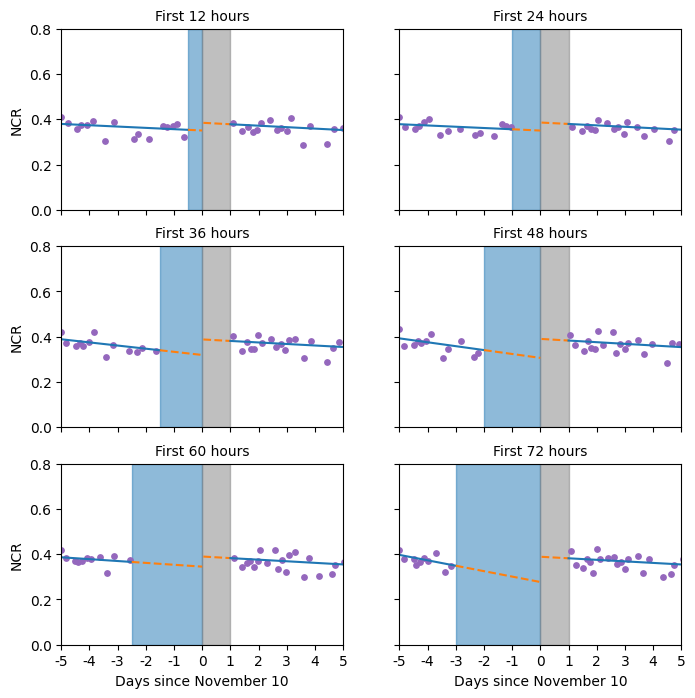

In [28]:
# Target name
target = 'ncr1'

# Init figure
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(8)

# Iterate over hours
for i, h in enumerate(hours):

    # Flatten axes
    ax = axs.flatten()[i]

    # Masks
    pre = d['r'].le(-h*60**2)
    pre_hat = d['r'].between(-h*60**2, 0)
    post_hat = d['r'].between(60**2, 24*60**2)
    post = d['r'].ge(24*60**2)

    # Predicted lines
    ax.plot(d.loc[pre, 'r'], d.loc[pre, f'{target}Post{h}'], color='C0')
    ax.plot(d.loc[pre_hat, 'r'], d.loc[pre_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post_hat, 'r'], d.loc[post_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post, 'r'], d.loc[post, f'{target}Post{h}'], color='C0')

    # Shaded regions
    ax.axvspan(xmin=-h*60**2, xmax=0, color='C0', alpha=0.5)
    ax.axvspan(xmin=0, xmax=24*60**2, color='gray', alpha=0.5)
    
    # Aesthetics
    ax.set_title(f'First {h} hours', fontsize=10)
    ax.set_xticks(np.linspace(-5*24*60**2, 5*24*60**2+1, 11))
    ax.set_xticklabels(np.arange(-5, 5+1))
    if i > 3:
        ax.set_xlabel('Days since November 10')
    if i % 2 == 0:
        ax.set_ylabel('NCR')

    # Get grouped means from targets
    t = df[~df['r'].between(-h*60**2, 24*60**2)].copy()
    t['bins'] = pd.qcut(t['r'], 35)
    x = t.groupby('bins')[f'{target}Post{h}'].mean()
    
    # Plot bins from targets
    ax.scatter(
        [val.left for val in x.index.values],
        x.values,
        color='C4',
        s=15
    )

# Set limits
ax.set_xlim(-24*5*60**2, 24*5*60**2+1)
ax.set_ylim(0, 0.8)

# Save and show
plt.savefig('../../fig/fig_ncr1.png', dpi=200, bbox_inches='tight')
plt.show()

Create plots for `ncr2` models

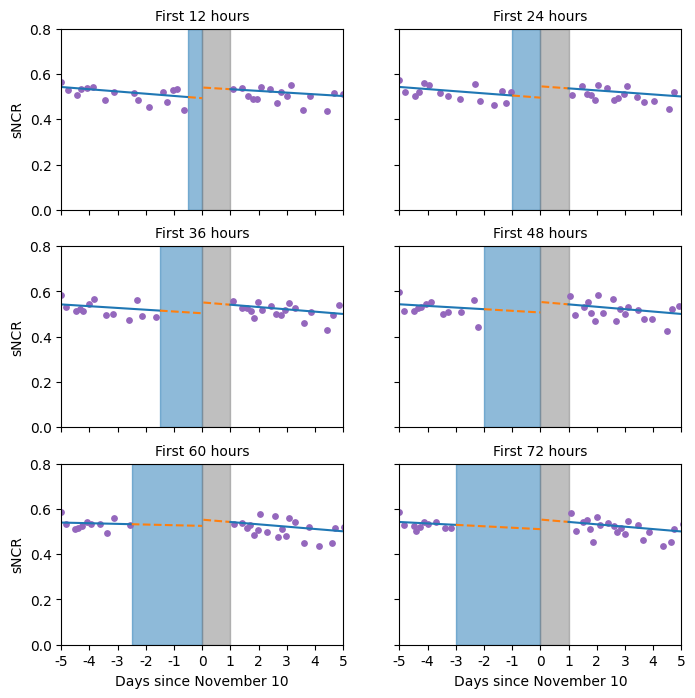

In [29]:
# Target name
target = 'ncr2'

# Init figure
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(8)

# Iterate over hours
for i, h in enumerate(hours):

    # Flatten axes
    ax = axs.flatten()[i]

    # Masks
    pre = d['r'].le(-h*60**2)
    pre_hat = d['r'].between(-h*60**2, 0)
    post_hat = d['r'].between(60**2, 24*60**2)
    post = d['r'].ge(24*60**2)

    # Predicted lines
    ax.plot(d.loc[pre, 'r'], d.loc[pre, f'{target}Post{h}'], color='C0')
    ax.plot(d.loc[pre_hat, 'r'], d.loc[pre_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post_hat, 'r'], d.loc[post_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post, 'r'], d.loc[post, f'{target}Post{h}'], color='C0')

    # Shaded regions
    ax.axvspan(xmin=-h*60**2, xmax=0, color='C0', alpha=0.5)
    ax.axvspan(xmin=0, xmax=24*60**2, color='gray', alpha=0.5)
    
    # Aesthetics
    ax.set_title(f'First {h} hours', fontsize=10)
    ax.set_xticks(np.linspace(-5*24*60**2, 5*24*60**2+1, 11))
    ax.set_xticklabels(np.arange(-5, 5+1))
    if i > 3:
        ax.set_xlabel('Days since November 10')
    if i % 2 == 0:
        ax.set_ylabel('sNCR')

    # Get grouped means from targets
    t = df[~df['r'].between(-h*60**2, 24*60**2)].copy()
    t['bins'] = pd.qcut(t['r'], 35)
    x = t.groupby('bins')[f'{target}Post{h}'].mean()
    
    # Plot bins from targets
    ax.scatter(
        [val.left for val in x.index.values],
        x.values,
        color='C4',
        s=15
    )

# Set limits
ax.set_xlim(-24*5*60**2, 24*5*60**2+1)
ax.set_ylim(0, 0.8)

# Save and show
plt.savefig('../../fig/fig_ncr2.png', dpi=200, bbox_inches='tight')
plt.show()

Create figure for example of fit ($h = 24$)

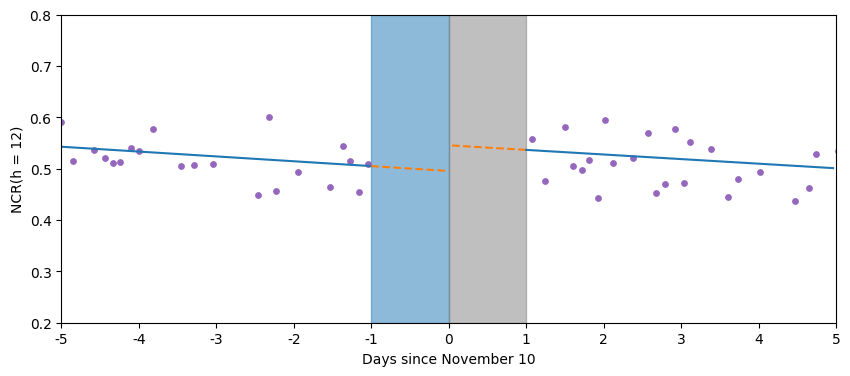

In [30]:
# Set fig dimensions
plt.figure(figsize=(10, 4))

# Declare hours
h = 24

# Masks
pre = d['r'].le(-h*60**2)
pre_hat = d['r'].between(-h*60**2, 0)
post_hat = d['r'].between(60**2, 24*60**2)
post = d['r'].ge(24*60**2)

# Model lines
plt.plot(d.loc[pre, 'r'], d.loc[pre, f'{target}Post{h}'], color='C0')
plt.plot(d.loc[pre_hat, 'r'], d.loc[pre_hat, f'{target}Post{h}'], color='C1', ls='--')
plt.plot(d.loc[post_hat, 'r'], d.loc[post_hat, f'{target}Post{h}'], color='C1', ls='--')
plt.plot(d.loc[post, 'r'], d.loc[post, f'{target}Post{h}'], color='C0')

# Shaded regions
plt.axvspan(xmin=-h*60**2, xmax=0, color='C0', alpha=0.5)
plt.axvspan(xmin=0, xmax=24*60**2, color='gray', alpha=0.5)

# Aesthetics
plt.xticks(
    np.linspace(-5*24*60**2, 5*24*60**2+1, 11),
    labels=np.arange(-5, 5+1)
)
plt.xlabel('Days since November 10')
plt.ylabel('NCR(h = 12)')

# Get grouped means from targets
t = df[~df['r'].between(-h*60**2, 24*60**2)].copy()
t['bins'] = pd.qcut(t['r'], 50)
x = t.groupby('bins')[f'{target}Post{h}'].mean()

# Plot bins from targets
plt.scatter(
    [val.left for val in x.index.values],
    x.values,
    color='C4',
    s=15
)

# Aesthetics
plt.ylim(0.2, 0.8)
plt.xlim(-5*h*60**2, 5*h*60**2+1)

# Save and show
plt.savefig('../../fig/fig_h24.png', dpi=200, bbox_inches='tight')
plt.show()